In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycountry_convert import country_name_to_country_alpha2
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster
from scipy.stats import zscore, mannwhitneyu

pd.options.mode.chained_assignment = None

<font size=5><b> Did continents with higher median happiness scores do better in preventing COVID-19 deaths and the effects of the COVID-19 pandemic on the World Happiness Index per continent?</font>

<font size=4> This notebook uses data from three different datasets all downloaded from kaggle.com

1. World Happiness Report, 2005-Present - https://www.kaggle.com/datasets/usamabuttar/world-happiness-report-2005-present
2. Covid-19 Global Dataset - https://www.kaggle.com/datasets/josephassaker/covid19-global-dataset
3. Latitude and Longitude for Every Country and State - https://www.kaggle.com/datasets/paultimothymooney/latitude-and-longitude-for-every-country-and-state

The variables in the **"Covid-19 Global Dataset"** and in **"Latitude and Longitude for Every Country and State"** (the dataframe is used later in the notebook) are self-explanatory.

However,it is not perfectly clear what all variables in the **"World Happiness Report, 2005-Present"** dataset represent so abbreviated explanations from the dataset author will be pasted below:

1. **Log GDP per capita** is in terms of Purchasing Power Parity (PPP) adjusted to a constant 2017 international dollars, taken from the World Development Indicators (WDI) by the World Bank.The equation uses the natural log of GDP per capita, as this form fits the data significantly better than GDP per capita.
2. **Healthy life expectancy at birth** is constructed based on data from the World Health Organization (WHO) Global Health Observatory data repository, with data available for 2005, 2010, 2015, 2016, and 2019. To match this report’s sample period (2005-2022), interpolation and extrapolation are used.
3. **Social support** is the national average of the binary responses (0=no, 1=yes) to the Gallup World Poll (GWP) question “If you were in trouble, do you have relatives or friends you can count on to help you whenever you need them, or not?”
4. **Freedom to make life choices** is the national average of binary responses to the GWP question “Are you satisfied or dissatisfied with your freedom to choose what you do with your life?”
5. **Generosity** is the residual of regressing the national average of GWP responses to the donation question “Have you donated money to a charity in the past month?” on log GDP per capita.
6. **Perceptions of corruption** are the average of binary answers to two GWP questions: “Is corruption widespread throughout the government or not?” and “Is corruption widespread within businesses or not?” Where data for government corruption are missing, the perception of business corruption is used as the overall corruption perception measure.
7. **Positive affect** is defined as the average of previous-day effects measures for laughter, enjoyment, and interest
8. **Negative affect** is defined as the average of previous-day effects measures for worry, sadness, and anger.



*(for a thorough explanation of the variables please visit: https://www.kaggle.com/datasets/usamabuttar/world-happiness-report-2005-present)*

The "Life Ladder" score is based on a Cantril Ladder which "asks respondents to think of a ladder, with the best possible life for them being a 10 and the worst possible life being a 0".

The World Happiness Report compiles Life Ladder scores from various national surveys conducted around the world and uses these scores to rank countries based on their levels of happiness and well-being while aggregating the scores with the other factors listed above.

### Loading the datasets and getting a general overview of the columns, values and shapes

In [ ]:
covid_19_global_daily = pd.read_csv("data\Covid-19 Global Dataset\worldometer_coronavirus_daily_data.csv")

In [ ]:
covid_19_global_daily.head()

,date,country,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
0,2020-2-15,Afghanistan,0.0,NaN,0.0,0.0,NaN
1,2020-2-16,Afghanistan,0.0,NaN,0.0,0.0,NaN
2,2020-2-17,Afghanistan,0.0,NaN,0.0,0.0,NaN
3,2020-2-18,Afghanistan,0.0,NaN,0.0,0.0,NaN
4,2020-2-19,Afghanistan,0.0,NaN,0.0,0.0,NaN


In [ ]:
covid_19_global_daily.shape

(184787, 7)

In [ ]:
covid_19_global_summary = pd.read_csv("data\Covid-19 Global Dataset\worldometer_coronavirus_summary_data.csv")

In [ ]:
covid_19_global_summary.head()

,country,continent,total_confirmed,total_deaths,total_recovered,active_cases,serious_or_critical,total_cases_per_1m_population,total_deaths_per_1m_population,total_tests,total_tests_per_1m_population,population
0,Afghanistan,Asia,179267,7690.0,162202.0,9375.0,1124.0,4420,190.0,951337.0,23455.0,40560636
1,Albania,Europe,275574,3497.0,271826.0,251.0,2.0,95954,1218.0,1817530.0,632857.0,2871945
2,Algeria,Africa,265816,6875.0,178371.0,80570.0,6.0,5865,152.0,230861.0,5093.0,45325517
3,Andorra,Europe,42156,153.0,41021.0,982.0,14.0,543983,1974.0,249838.0,3223924.0,77495
4,Angola,Africa,99194,1900.0,97149.0,145.0,NaN,2853,55.0,1499795.0,43136.0,34769277


In [ ]:
covid_19_global_summary.shape

(226, 12)

In [ ]:
happiness_2005_present = pd.read_csv("data\World Happines Report, 2005 to Present\World Happiness Report.csv")

In [ ]:
happiness_2005_present.head()

,Country Name,Regional Indicator,Year,Life Ladder,Log GDP Per Capita,Social Support,Healthy Life Expectancy At Birth,Freedom To Make Life Choices,Generosity,Perceptions Of Corruption,Positive Affect,Negative Affect,Confidence In National Government
0,Afghanistan,South Asia,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.167652,0.881686,0.414297,0.258195,0.612072
1,Afghanistan,South Asia,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.190809,0.850035,0.481421,0.237092,0.611545
2,Afghanistan,South Asia,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.121316,0.706766,0.516907,0.275324,0.299357
3,Afghanistan,South Asia,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.163571,0.731109,0.479835,0.267175,0.307386
4,Afghanistan,South Asia,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.237588,0.775620,0.613513,0.267919,0.435440


In [ ]:
happiness_2005_present.shape

(2199, 13)

The "Country" columns can be used as key on which to merge the dataframes.

However, we would first need to check the number of countries in each dataframe and where the countries actually intersect.

In [ ]:
print(f"Number of unique countries in the daily dataframe: {covid_19_global_daily.country.nunique()}")

Number of unique countries in the daily dataframe: 226


In [ ]:
print(f"Number of unique countries in the summary dataframe: {covid_19_global_summary.country.nunique()}")

Number of unique countries in the summary dataframe: 226


In [ ]:
print(f"Number of unique countries in the happpiness dataframe: {happiness_2005_present['Country Name'].nunique()}")

Number of unique countries in the happpiness dataframe: 165


Check if the countries in the two Covid-19 dataframes intersect 1-to-1 and afterword which countries in the "happiness_2005_present" dataframe intersect with "covid_19_global_summary"

In [ ]:
print(f"Number of intersecting countries between the two Covid-19 dataframes: \
{len(set(covid_19_global_daily.country.unique()).intersection(set(covid_19_global_summary.country.unique())))}")

# Assert that the number of unique countries in both Covid-19 datasets are equal to their intersection
assert covid_19_global_daily.country.nunique() == \
len(set(covid_19_global_daily.country.unique()).intersection(set(covid_19_global_summary.country.unique()))),\
"Countries in one of the datasets are not present in the other"

Number of intersecting countries between the two Covid-19 dataframes: 226


In [ ]:
print("Number of countries intersecting between the Happpiness and Covid-19 summary datasets:")

len(set(happiness_2005_present['Country Name'].unique()).intersection(set(covid_19_global_summary.country.unique())))

Number of countries intersecting between the Happpiness and Covid-19 summary datasets:


147

In [ ]:
#Save the 147 countries to a variable as we are going to use them later
countries_intersect = set(happiness_2005_present['Country Name'].unique()).intersection(set(covid_19_global_summary.country.unique()))

In [ ]:
print("The countries that are present in the Happiness dataframe but not in the Covid-19 one:")

set(happiness_2005_present['Country Name'].unique()).difference(set(covid_19_global_summary.country.unique()))

The countries that are present in the Happiness dataframe but not in the Covid-19 one:


{'Bosnia and Herzegovina',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Czechia',
 'Eswatini',
 'Hong Kong S.A.R. of China',
 'Ivory Coast',
 'Kosovo',
 'North Macedonia',
 'Somaliland region',
 'State of Palestine',
 'Taiwan Province of China',
 'Trinidad and Tobago',
 'Turkiye',
 'Turkmenistan',
 'United Kingdom',
 'United States',
 'Vietnam'}

#### In order to have unique intersecting values that would later help us in merging different columns from the dataframes, we would leave only the 147 countries present in all three dataframes and drop all other countries.

#### Additionally, we would rename the columns of the Covid-19 dataframes by replacing the underscores for spaces and capitalizing everything.

#### The columns with country names in the three dataframes will be set to "Country"

In [ ]:
def replace_and_capitalize(df):
    df.columns = [column.replace("_", " ").capitalize() for column in df.columns]
    return df

In [ ]:
#Capitalize all columns and replace underscores with spaces where applicable in the covid-19 dataframes

happiness_2005_present  = replace_and_capitalize(happiness_2005_present)

covid_19_global_daily = replace_and_capitalize(covid_19_global_daily)

covid_19_global_summary = replace_and_capitalize(covid_19_global_summary)

In [ ]:
#Rename "Country name" to "Country"
happiness_2005_present.rename(columns={"Country name": "Country"}, inplace=True)

In [ ]:
happiness_2005_present["Country"].nunique()

165

In [ ]:
def intersection_only(df):
    """
    Filter the dataframes
    and leave only the intersecting countries
    """
    df = df[df["Country"].isin(countries_intersect)]
    return df

In [ ]:
#Create new dataframes that consists only of the 147 countries
happiness_data = intersection_only(happiness_2005_present)
covid_19_daily = intersection_only(covid_19_global_daily)
covid_19_summary = intersection_only(covid_19_global_summary)

In [ ]:
assert len(countries_intersect) == happiness_data.Country.nunique(), "The unique countries are not 147"

In [ ]:
assert len(countries_intersect) == covid_19_daily.Country.nunique(), "The unique countries are not 147"

In [ ]:
assert len(countries_intersect) == covid_19_summary.Country.nunique(), "The unique countries are not 147"

# Descriptive statistics and review of missing values and datatypes

Use `pd.info()` to get a better understanding of missing values and dtypes

In [ ]:
happiness_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1976 entries, 0 to 2198
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Country                            1976 non-null   object 
 1   Regional indicator                 1930 non-null   object 
 2   Year                               1976 non-null   int64  
 3   Life ladder                        1976 non-null   float64
 4   Log gdp per capita                 1965 non-null   float64
 5   Social support                     1965 non-null   float64
 6   Healthy life expectancy at birth   1976 non-null   float64
 7   Freedom to make life choices       1949 non-null   float64
 8   Generosity                         1918 non-null   float64
 9   Perceptions of corruption          1875 non-null   float64
 10  Positive affect                    1954 non-null   float64
 11  Negative affect                    1962 non-null   float

In [ ]:
covid_19_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147 entries, 0 to 225
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Country                         147 non-null    object 
 1   Continent                       147 non-null    object 
 2   Total confirmed                 147 non-null    int64  
 3   Total deaths                    147 non-null    float64
 4   Total recovered                 131 non-null    float64
 5   Active cases                    131 non-null    float64
 6   Serious or critical             105 non-null    float64
 7   Total cases per 1m population   147 non-null    int64  
 8   Total deaths per 1m population  147 non-null    float64
 9   Total tests                     143 non-null    float64
 10  Total tests per 1m population   143 non-null    float64
 11  Population                      147 non-null    int64  
dtypes: float64(7), int64(3), object(2)
m

In [ ]:
covid_19_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120564 entries, 0 to 184786
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Date                     120564 non-null  object 
 1   Country                  120564 non-null  object 
 2   Cumulative total cases   120564 non-null  float64
 3   Daily new cases          117484 non-null  float64
 4   Active cases             107444 non-null  float64
 5   Cumulative total deaths  120564 non-null  float64
 6   Daily new deaths         114866 non-null  float64
dtypes: float64(5), object(2)
memory usage: 7.4+ MB


All column dtypes seem correct.

We can turn all covid_19 columns into int64 since they should represent whole numbers but we'll leave them as they are and perform any dtype changes in case necessary later.

In [ ]:
#Missing values per column in covid_19_summary
print(covid_19_summary.isna().sum())
print(f"\nThe sum of all missing values: {covid_19_summary.isna().sum().sum()}")

Country                            0
Continent                          0
Total confirmed                    0
Total deaths                       0
Total recovered                   16
Active cases                      16
Serious or critical               42
Total cases per 1m population      0
Total deaths per 1m population     0
Total tests                        4
Total tests per 1m population      4
Population                         0
dtype: int64

The sum of all missing values: 82


In [ ]:
#Missing values per column in happiness_data
print(happiness_data.isna().sum())
print(f"\nThe sum of all missing values: {happiness_data.isna().sum().sum()}")

Country                                0
Regional indicator                    46
Year                                   0
Life ladder                            0
Log gdp per capita                    11
Social support                        11
Healthy life expectancy at birth       0
Freedom to make life choices          27
Generosity                            58
Perceptions of corruption            101
Positive affect                       22
Negative affect                       14
Confidence in national government    293
dtype: int64

The sum of all missing values: 583


We won't drop any missing values from the "happiness_data" dataframe since we would loose too much data in the process.

We'll decide how to fill the missing values later based on the distributions of the variables.

The "Regional indicator" column will be dropped as in order to fill the 46 missing values, we would have to manually check and fill the region of each country.

Also, at a later point we will add the "Continent" column from "**covid_19_summary**" that would (to some extend) serve a similar purpose as the "Regional indicator".

In [ ]:
#Drop the "Regional indicator" column
happiness_data.drop("Regional indicator", axis=1, inplace=True)

In [ ]:
happiness_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,1976.0,2014.151822,4.734172,2005.000000,2010.000000,2014.000000,2018.000000,2022.000000
Life ladder,1976.0,5.467612,1.145515,1.281271,4.616669,5.432026,6.295051,8.018934
Log gdp per capita,1965.0,9.366469,1.160850,5.526723,8.460876,9.494558,10.345787,11.663788
Social support,1965.0,0.809476,0.123314,0.228217,0.742304,0.836539,0.906029,0.987343
Healthy life expectancy at birth,1976.0,63.274519,6.976322,6.720000,58.972500,64.949997,68.657501,74.474998
Freedom to make life choices,1949.0,0.750988,0.138659,0.260069,0.659177,0.771351,0.863305,0.985178
Generosity,1918.0,-0.002978,0.161349,-0.337527,-0.114146,-0.026341,0.086958,0.702708
Perceptions of corruption,1875.0,0.743965,0.187632,0.035198,0.686784,0.800047,0.868599,0.983276
Positive affect,1954.0,0.656443,0.105381,0.178886,0.577989,0.668041,0.740147,0.883586
Negative affect,1962.0,0.272349,0.086172,0.095490,0.208525,0.261219,0.322772,0.704590


The minimum "Life ladder" value seems to be around 3.5 standard deviations from the mean.

Let's review the z-scores of the "Life Ladder" to check how standard deviations away from the mean are the lowest scores.

In [ ]:
#Check the 5 smallest z-scores
zscore(happiness_data["Life ladder"]).nsmallest()

13     -3.655474
1116   -2.871752
1117   -2.720150
11     -2.700360
12     -2.647146
Name: Life ladder, dtype: float64

In [ ]:
#Check the 5 largest z-scores
zscore(happiness_data["Life ladder"]).nlargest()

505    2.227791
507    2.185841
635    2.114639
633    2.087359
506    2.066512
Name: Life ladder, dtype: float64

Looks like the smallest "Life ladder" score belongs to Afghanistan for 2022.

When we check the "Life ladder" for the previous year in Afghanistan the value is almost twice as big.

However, the possible explanation for the extremely low value in 2022 is that in August 2021, the Taliban invaded and overtook Afghanistan.


An article in the Council of Foreign Relations informs us that since the Taliban insurgency, "malnutrition has soared" , "hundreds of thousands of jobs have been lost" and "most women have been banned from working" amongst many other troublesome things (https://www.cfr.org/backgrounder/taliban-afghanistan).

The other two values in the lowest (indexes 1116 and 1117) are related to Lebanon in 2021 and 2022.

Given that the "The Economist Intelligence Unit" classified Lebanon as "authoritarian regime" in its 2021 Democratic Index, tells a lot about the "Life ladder" scores (https://www.eiu.com/n/campaigns/democracy-index-2022/).

In [ ]:
happiness_data.loc[13,:]

Country                              Afghanistan
Year                                        2022
Life ladder                             1.281271
Log gdp per capita                           NaN
Social support                          0.228217
Healthy life expectancy at birth          54.875
Freedom to make life choices            0.368377
Generosity                                   NaN
Perceptions of corruption               0.733198
Positive affect                         0.205868
Negative affect                         0.575512
Confidence in national government            NaN
Name: 13, dtype: object

In [ ]:
happiness_data.loc[12,:]

Country                              Afghanistan
Year                                        2021
Life ladder                             2.436034
Log gdp per capita                      7.324032
Social support                          0.454175
Healthy life expectancy at birth       54.549999
Freedom to make life choices            0.394306
Generosity                             -0.081011
Perceptions of corruption               0.946299
Positive affect                         0.178886
Negative affect                         0.606713
Confidence in national government        0.25562
Name: 12, dtype: object

In [ ]:
happiness_data.loc[1116,:]

Country                                Lebanon
Year                                      2021
Life ladder                           2.178809
Log gdp per capita                    9.470949
Social support                        0.506775
Healthy life expectancy at birth     66.150002
Freedom to make life choices          0.422697
Generosity                           -0.161281
Perceptions of corruption             0.905279
Positive affect                       0.263487
Negative affect                       0.569101
Confidence in national government     0.106694
Name: 1116, dtype: object

In [ ]:
covid_19_summary.describe().T

,count,mean,std,min,25%,50%,75%,max
Total confirmed,147.0,2.580493e+06,5.964129e+06,7414.0,124843.5,576997.0,1931480.0,4.312160e+07
Total deaths,147.0,3.294324e+04,8.602431e+04,21.0,1377.5,5798.0,20992.0,6.649200e+05
Total recovered,131.0,2.492709e+06,5.944821e+06,4225.0,93612.5,514836.0,1791549.5,4.257969e+07
Active cases,131.0,7.019302e+04,2.045998e+05,0.0,552.0,4732.0,43136.0,1.685607e+06
Serious or critical,105.0,3.364476e+02,1.009872e+03,1.0,8.0,47.0,192.0,8.318000e+03
Total cases per 1m population,147.0,1.259574e+05,1.440286e+05,154.0,6902.0,71240.0,195252.0,5.401340e+05
Total deaths per 1m population,147.0,1.132884e+03,1.263959e+03,3.0,138.5,631.0,1839.5,6.297000e+03
Total tests,143.0,3.082166e+07,9.079359e+07,81294.0,1438855.0,4795578.0,19037544.5,8.438369e+08
Total tests per 1m population,143.0,1.612741e+06,3.164819e+06,5093.0,119683.5,442197.0,1602908.5,2.184247e+07
Population,147.0,4.829776e+07,1.683535e+08,345368.0,5021304.5,11661401.0,34570896.0,1.439324e+09


We won't delve too deep into analysing the data from the **"covid_19_summary"** datasets. The reason for this is that throughout the pandemic, it became apparent that acquiring, storing, processing and all other steps of the data management workflow are extremely difficult when you want to unify and aggregate data from a global scale perspective.

The challenges concerning Covid-19 have been multifaceted to the level where even investigating the reporting of administered tests around the world is a thesis material on its own.

Factors like different levels of socio-economical development, technological capabilities, healthcare system resources, and political systems, are just a few that result in how and what types of data reach us and how accurate it is for the purposes of our work.

With the aforementioned in mind, we won't focus too much on looking for patterns or outliers in the Covid-19 data.

1. https://gh.bmj.com/content/6/5/e005542 - Challenges in reported COVID-19 data: best practices and recommendations for future epidemics
2. https://health-policy-systems.biomedcentral.com/articles/10.1186/s12961-023-00963-1 - Limitations of COVID-19 testing and case data for evidence-informed health policy and practice
3. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9458694/#:~:text=Seven%20categories%20influencing%20international%20collaboration,(7)%20process%2Faction. - Factors influencing international collaboration on the prevention of COVID-19
4. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7682961/ - Problems with the accurate reporting of COVID-19 statistics in Iran



**Note**: For the rest of the notebook we will use only the "happiness_data" and "covid_19_summary" for the purposes of the analysis.

# Data Visualization

## Create a world map that shows all the countries that are going to be used for the analysis.

The extraction of "Code", "Latitude and Longitude" and creation of a world map were all done thanks to the code provided in the following TDS article - https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10

However, due to issues with the Nominatim "longitude" and "latitude" extraction, a Kaggle dataset (https://www.kaggle.com/datasets/paultimothymooney/latitude-and-longitude-for-every-country-and-state) with correct latitudes and longitudes has been downloaded in order to have all country-markers visualized in the correct region.

Two maps - one before and one after downloading and using the latitude-longitute dataset - have been left in the notebook to showcase what went wrong.

In [ ]:
def get_code(col):
    """
    A function that uses 'pycountry_convert'
    to extract the two-letter country code
    from the country name
    """
    try:
        cn_a2_code = country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown'
    return cn_a2_code

In [ ]:
covid_19_summary["Code"] = covid_19_summary["Country"].apply(lambda x: get_code(x))

In [ ]:
def geolocate(country_code):
    geolocator = Nominatim(user_agent = "Dido")

    """
    Using Geopy to extract the latitude and longitude
    based on the two-letter country codes
    """

    # Geolocate the center of the country
    location = geolocator.geocode(country_code, exactly_one = True)

    # And return latitude and longitude
    if location:
        latitude = location.latitude
        longitude = location.longitude

        return latitude, longitude

    else:
        return None, None

In [ ]:
#Save the latitude and longitude into a variable
#This is the code in the notebook that requires most time to run (around 90 seconds on my PC)

latitude_longitude = covid_19_summary["Code"].apply(lambda x: geolocate(x))

In [ ]:
#Create a column with the latitude and longitude

covid_19_summary["LatLong"] = latitude_longitude

In [ ]:
def extract_first_value(tuple_value):
    """
    A function that returns the first value of a tuple
    """
    try:
        return tuple_value[0]
    except (TypeError, IndexError):
        return np.nan

def extract_second_value(tuple_value):
    """
    A function that returns the second value of a tuple
    """
    try:
        return tuple_value[1]
    except (TypeError, IndexError):
        return np.nan

In [ ]:
#Create separate columns for latitude and longitude

covid_19_summary["Latitude"] = covid_19_summary["LatLong"].apply(extract_first_value)
covid_19_summary["Longitude"] = covid_19_summary["LatLong"].apply(extract_second_value)

In [ ]:
#Drop the obsolete "LatLong" column

covid_19_summary.drop("LatLong", axis=1, inplace=True)

Create a world map with Folium and add markers that show the total number of deaths for each country

In [ ]:
#empty map
world_map = folium.Map(tiles="cartodbpositron")

marker_cluster = MarkerCluster().add_to(world_map)

#for each coordinate, create circlemarker of total deaths
for i in range(len(covid_19_summary)):

        lat = covid_19_summary.iloc[i]['Latitude']
        long = covid_19_summary.iloc[i]['Longitude']
        radius=5
        popup_text = """Country : {}<br>
                    %of Total Deaths : {}<br>"""

        popup_text = popup_text.format(covid_19_summary.iloc[i]['Country'],
                                   covid_19_summary.iloc[i]['Total deaths']
                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map

#### Checking the map above, we can see the Nicaragua is placed in Belfast, Russia is not in Russia at all, Moldova is placed on Maryland (USA), etc.
#### That's why, we'll load a dataset with the correct latitudes and longitudes and try creating the map again

In [ ]:
lat_long_data = pd.read_csv("data\world_country_and_usa_states_latitude_and_longitude_values.csv")

In [ ]:
lat_long_data.head()

,country_code,latitude,longitude,country,usa_state_code,usa_state_latitude,usa_state_longitude,usa_state
0,AD,42.546245,1.601554,Andorra,AK,63.588753,-154.493062,Alaska
1,AE,23.424076,53.847818,United Arab Emirates,AL,32.318231,-86.902298,Alabama
2,AF,33.939110,67.709953,Afghanistan,AR,35.201050,-91.831833,Arkansas
3,AG,17.060816,-61.796428,Antigua and Barbuda,AZ,34.048928,-111.093731,Arizona
4,AI,18.220554,-63.068615,Anguilla,CA,36.778261,-119.417932,California


Let's first check if all the countries in "covid_19_summary" are present in "lat_long_data".

In [ ]:
len(covid_19_summary["Country"]) == \
len(set(covid_19_summary["Country"].unique()).intersection(set(lat_long_data["country"].unique())))

False

Some countries are missing. Let's check which:

In [ ]:
print("Countries missing in 'lat_long_data':")
set(covid_19_summary["Country"].unique()).difference(set(lat_long_data["country"].unique()))

Countries missing in 'lat_long_data':


{'Myanmar', 'South Sudan'}

Fortunately, we have the correct latitude and longitude values for "Myanmar" and "South Sudan" (from Nominatim) in **"covid_19_summary"** so we can proceed.

In [ ]:
def code_to_latlong(df, lat_long):

    """
    Loop over all country codes in 'df',
    then take the latitude and longitude values
    from 'lat_long' based on the country code,
    and change the values in 'df' with the new ones.
    """

    for index, country_code in df["Code"].items():
        if country_code in lat_long["country_code"].unique():

            lat_data = lat_long[lat_long["country_code"] == country_code]["latitude"]
            long_data = lat_long[lat_long["country_code"] == country_code]["longitude"]

            df.loc[index,"Latitude"] = lat_data.values[0]
            df.loc[index,"Longitude"] = long_data.values[0]

    return df

In [ ]:
covid_19_summary_new = code_to_latlong(covid_19_summary,lat_long_data)

In [ ]:
#Check if there are missing values in the "Latitude" and "Longitude" columns
covid_19_summary_new.isna().sum()

Country                            0
Continent                          0
Total confirmed                    0
Total deaths                       0
Total recovered                   16
Active cases                      16
Serious or critical               42
Total cases per 1m population      0
Total deaths per 1m population     0
Total tests                        4
Total tests per 1m population      4
Population                         0
Code                               0
Latitude                           0
Longitude                          0
dtype: int64

### Create the map again and explore visually for any obvious discrepancies

In [ ]:
#empty map
world_map = folium.Map(tiles="cartodbpositron")

marker_cluster = MarkerCluster().add_to(world_map)

#for each coordinate, create circlemarker of total deaths
for i in range(len(covid_19_summary)):
        lat = covid_19_summary_new.iloc[i]['Latitude']
        long = covid_19_summary_new.iloc[i]['Longitude']
        radius=5
        popup_text = """Country : {}<br>
                    %of Total Deaths : {}<br>"""

        popup_text = popup_text.format(covid_19_summary_new.iloc[i]['Country'],
                                   covid_19_summary_new.iloc[i]['Total deaths']
                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map

### Distributions of the "happiness" data

In [ ]:
hist_data = happiness_data[['Life ladder', 'Log gdp per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect',
       'Confidence in national government']]

In [ ]:
rows = 5
cols = 2

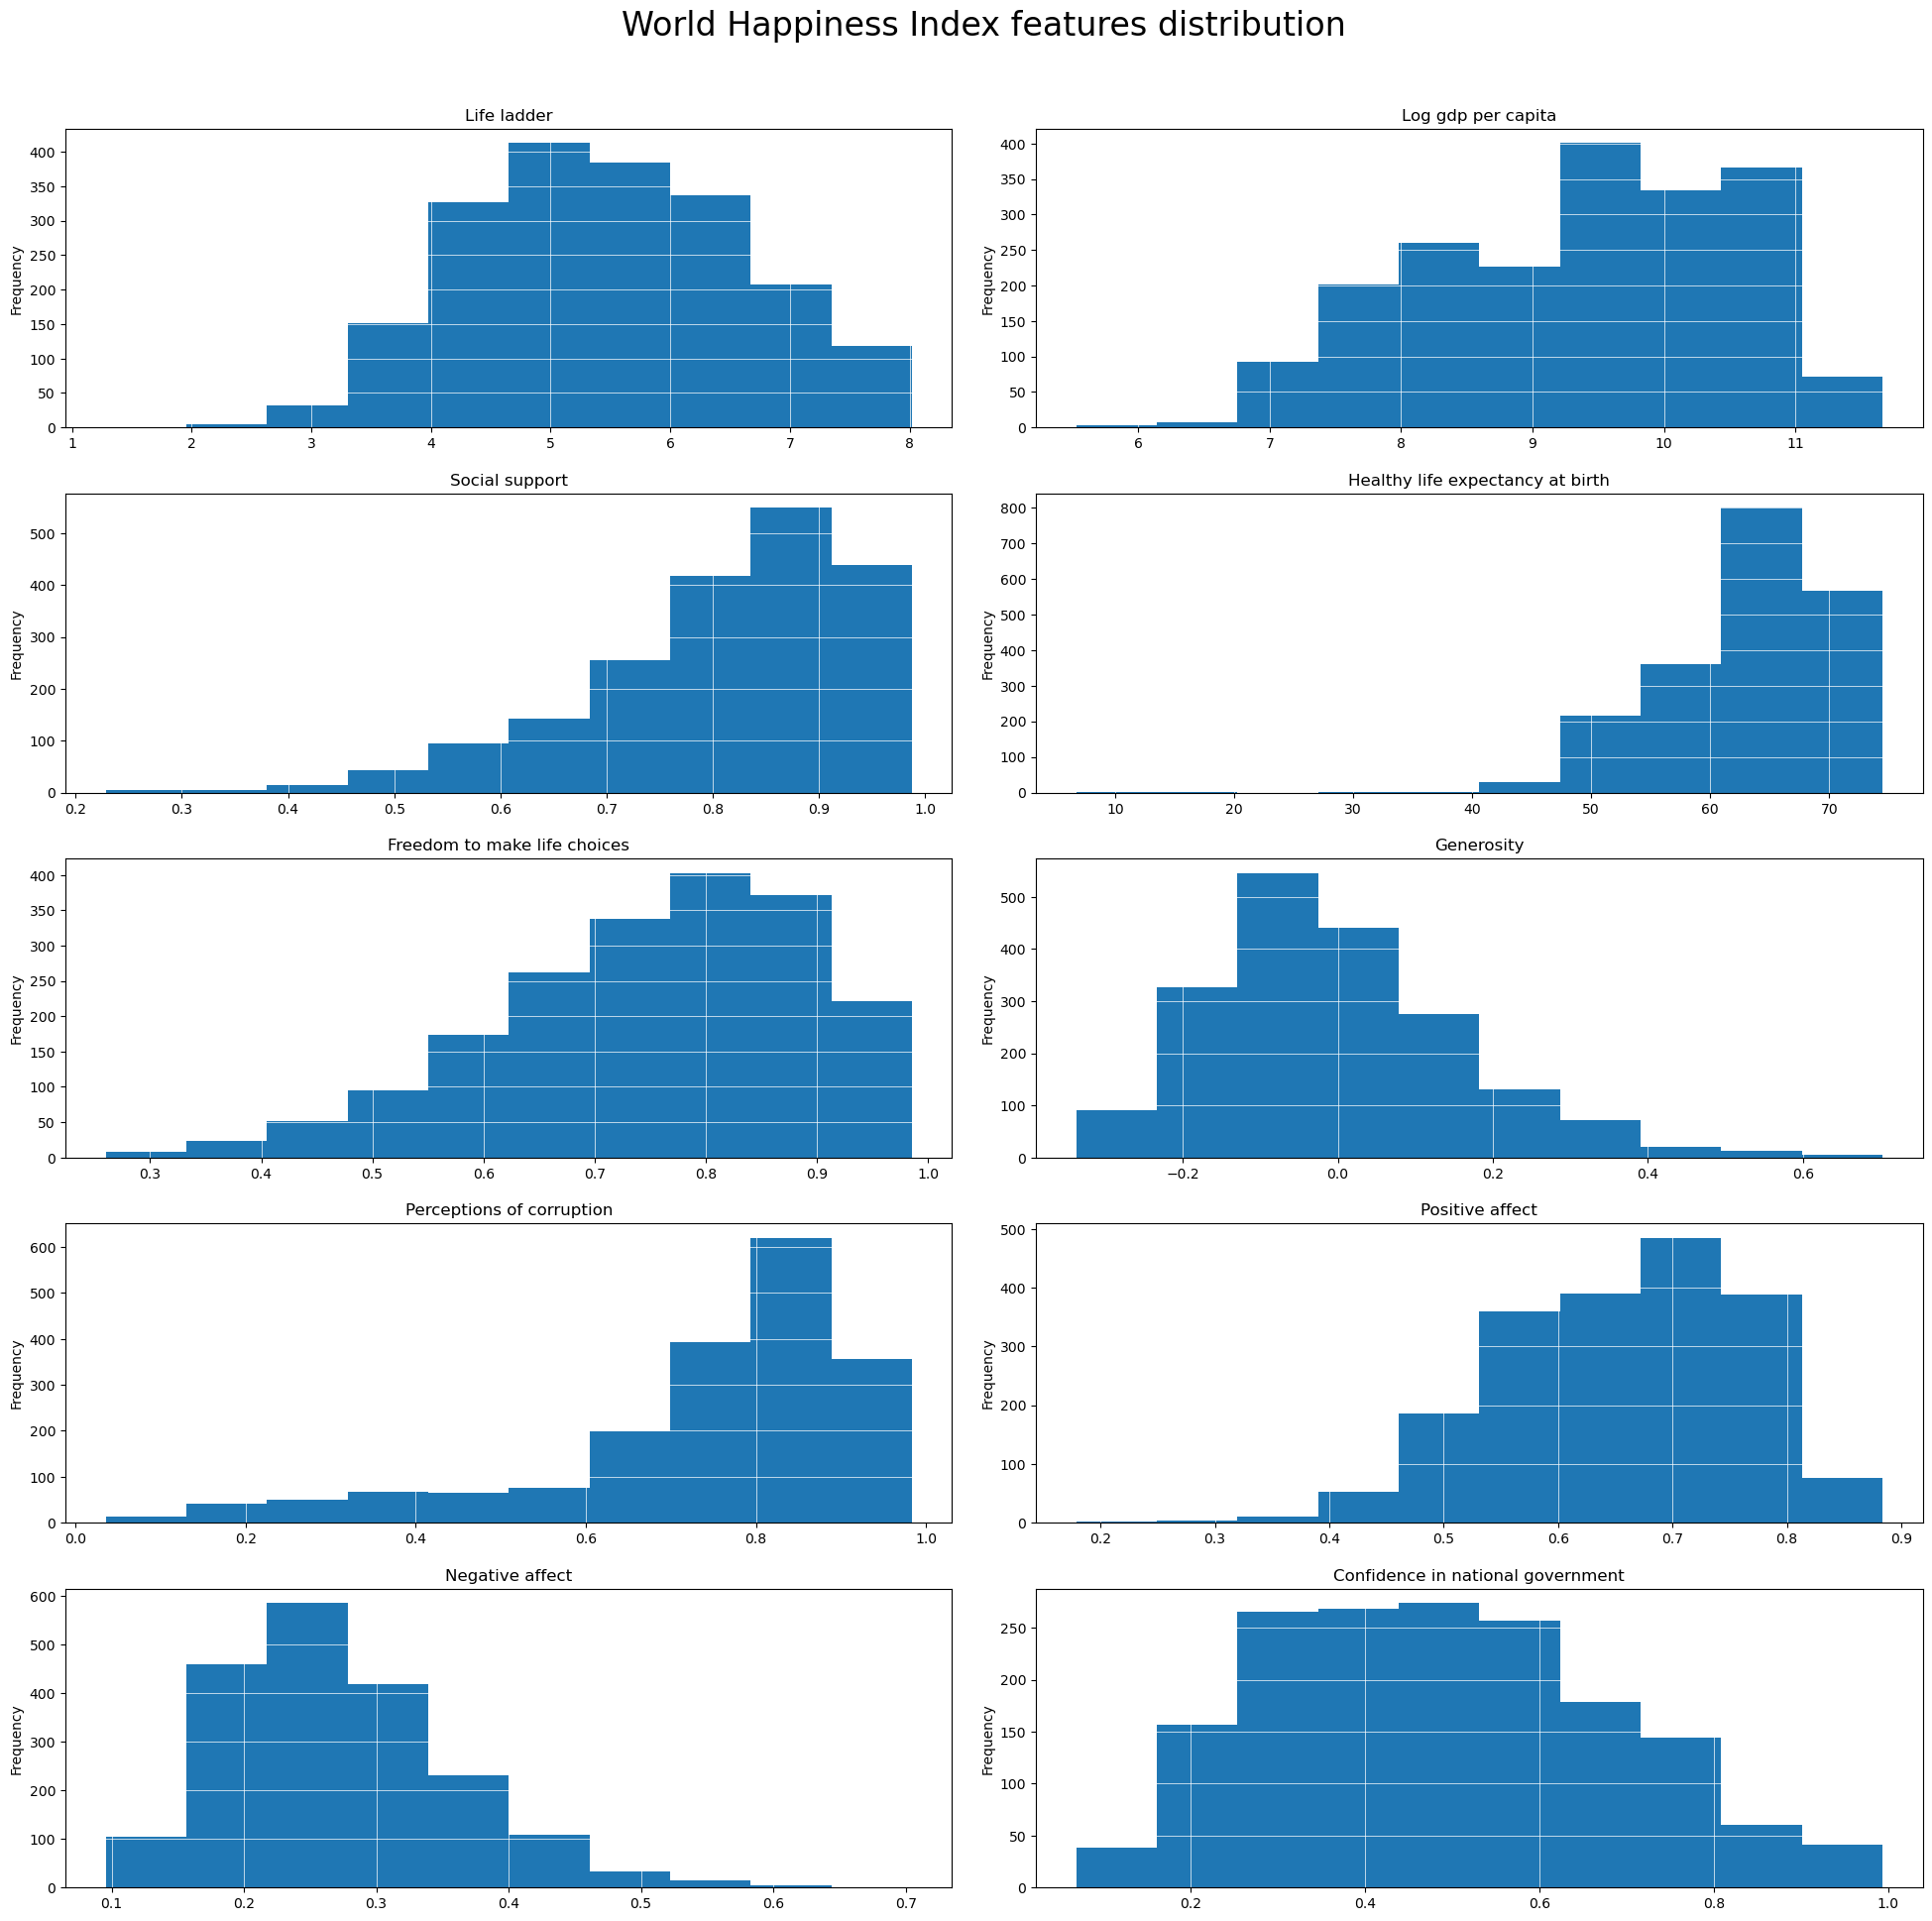

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))

# Adjust spacing between subplots
fig.tight_layout(pad=3.0)

for i, column in enumerate(hist_data.columns):
    # Get the current subplot axis
    ax = axes[i // cols, i % cols]

    # Plot histogram for the current column
    hist_data[column].plot.hist(ax=ax, bins=10)

    # Set subplot title
    ax.set_title(column)
    ax.grid(color='w', linestyle='-', linewidth=0.5)

plt.suptitle("World Happiness Index features distribution", fontsize=24)
plt.subplots_adjust(top=0.92)
plt.show()


### Distributions of the "covid-19" data

In [ ]:
hist_covid_19_summary = covid_19_summary[['Total confirmed', 'Total deaths',
       'Total recovered', 'Active cases', 'Serious or critical',
       'Total cases per 1m population', 'Total deaths per 1m population',
       'Total tests', 'Total tests per 1m population', 'Population']]

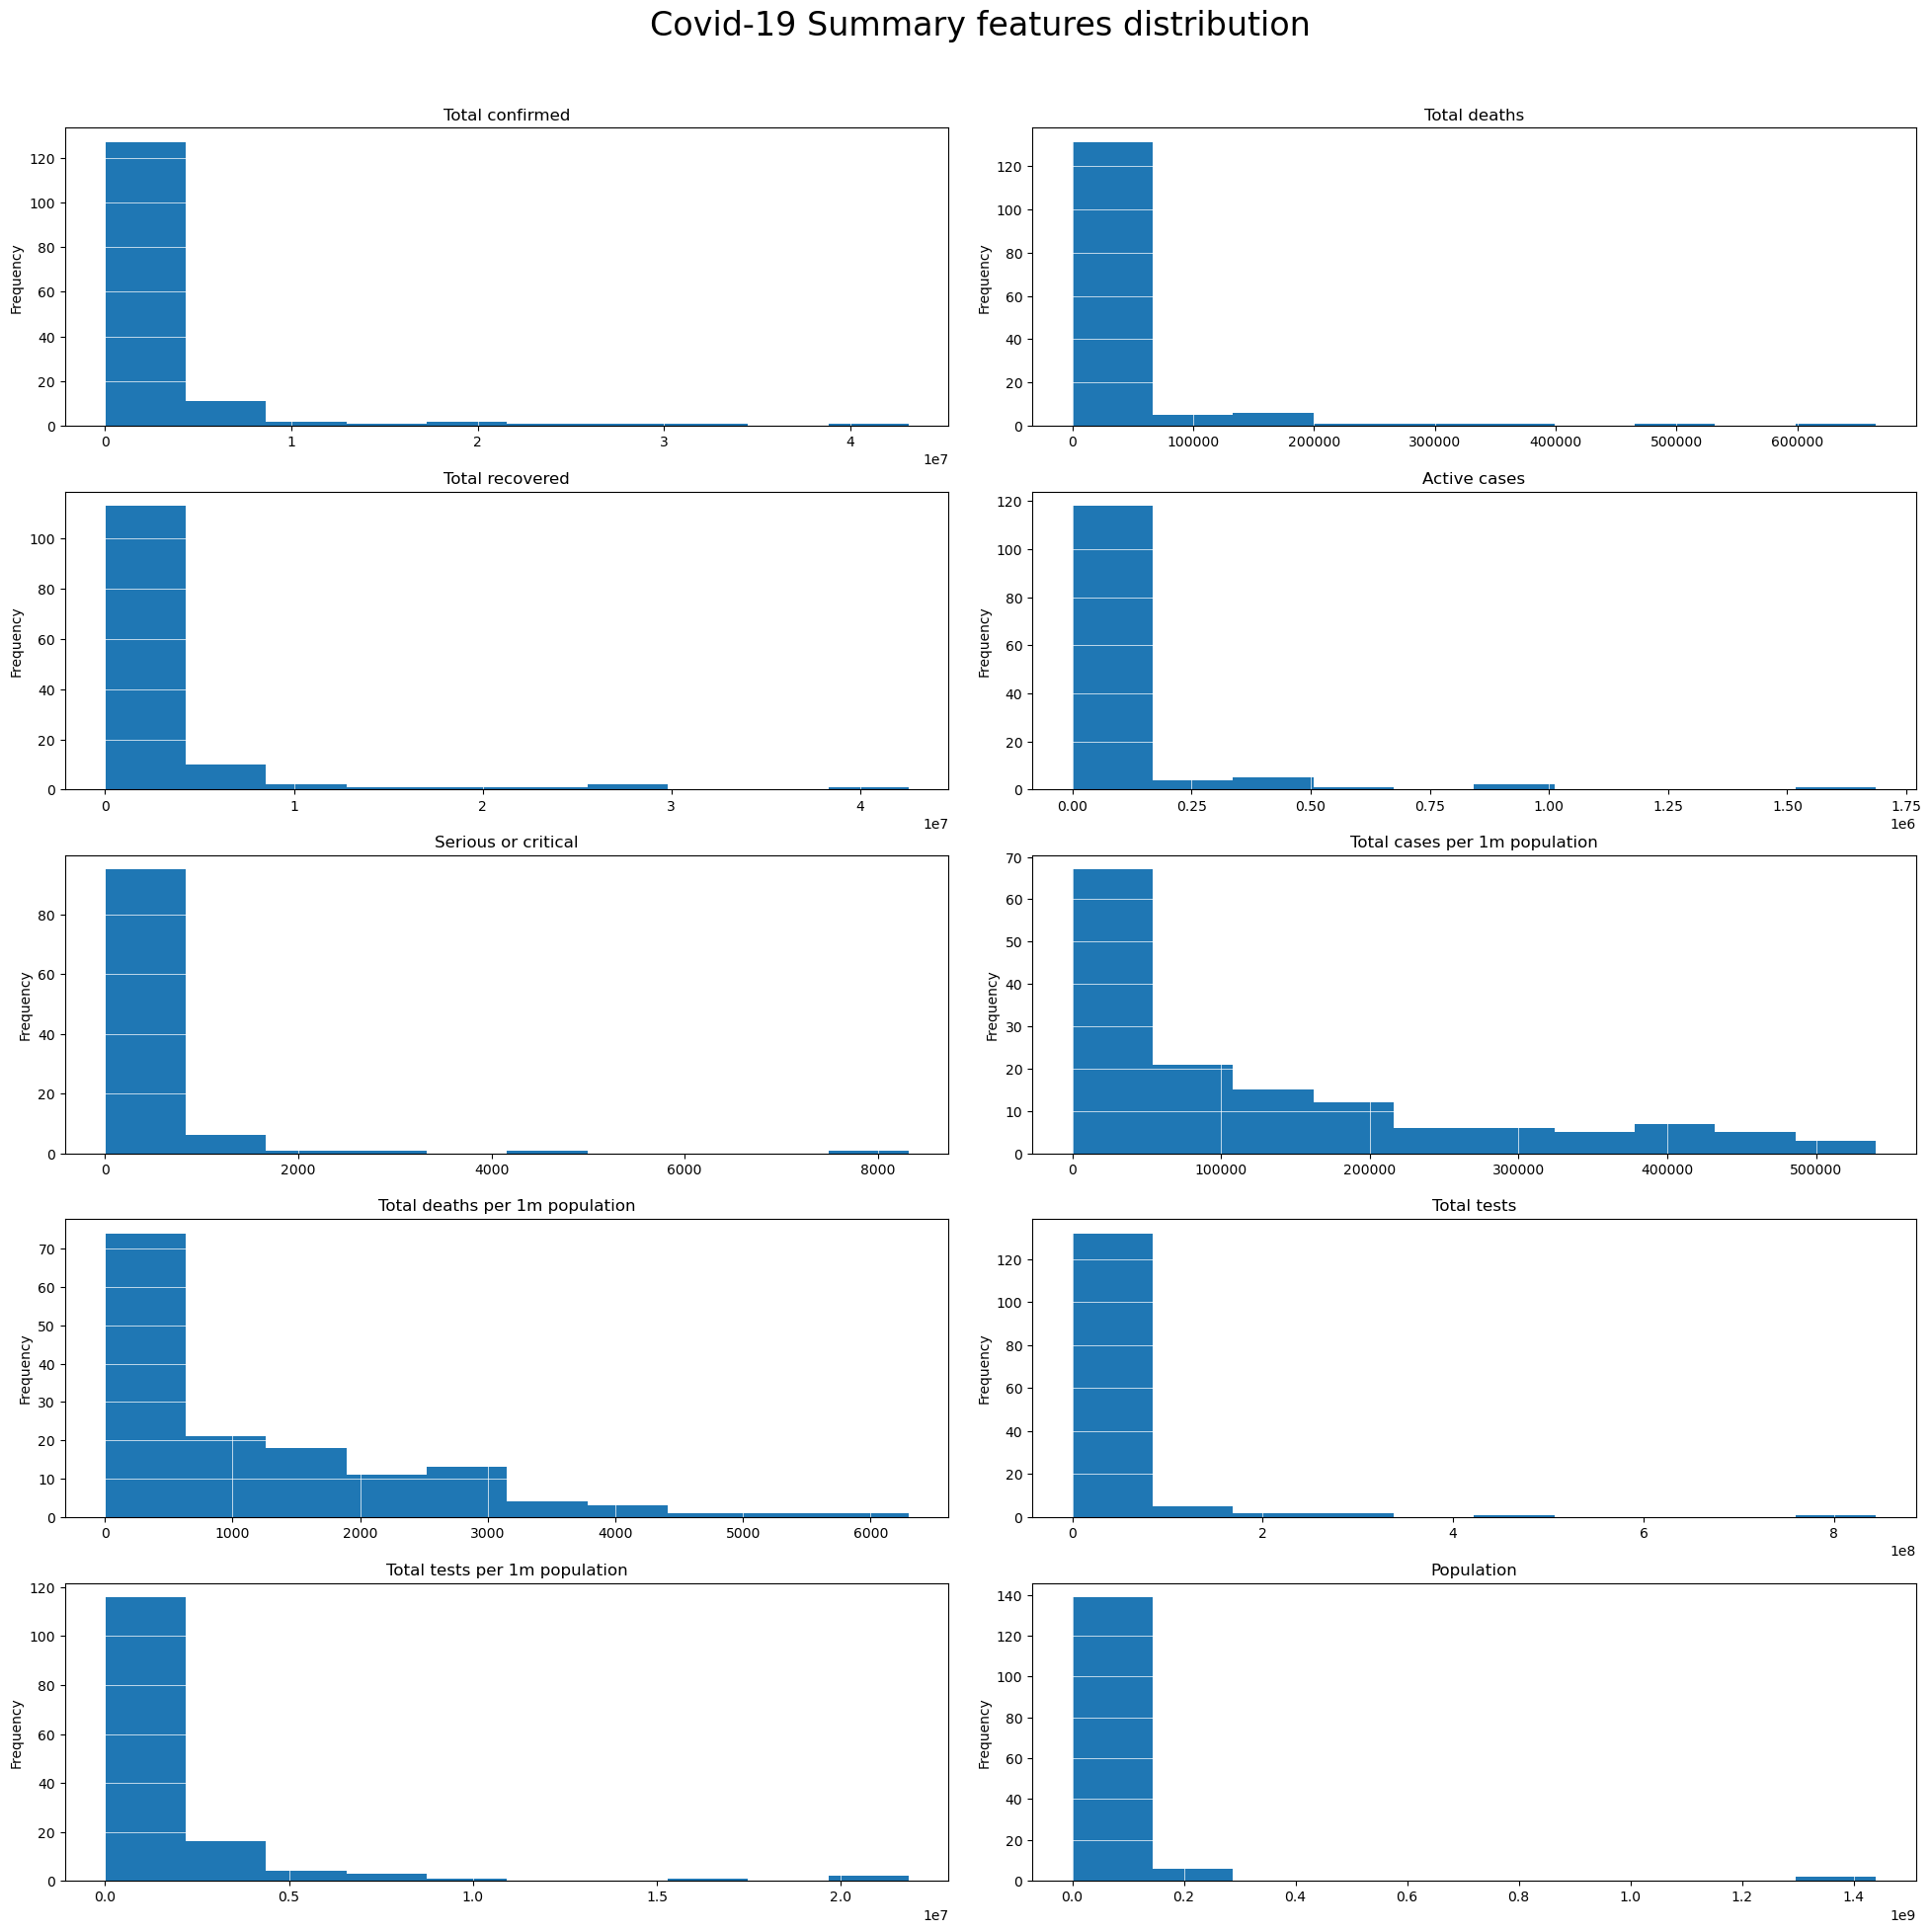

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
# Adjust spacing between subplots
fig.tight_layout(pad=3.0)

for i, column in enumerate(hist_covid_19_summary.columns):

    # Get the current subplot axis
    ax = axes[i // cols, i % cols]

    # Plot histogram for the current column
    hist_covid_19_summary[column].plot.hist(ax=ax, bins=10)

    # Set subplot title
    ax.set_title(column)
    ax.grid(color='w', linestyle='-', linewidth=0.5)

plt.suptitle("Covid-19 Summary features distribution", fontsize=24)
plt.subplots_adjust(top=0.92)
plt.show()


The data in both datasets is skewed.

Most features in the "happiness" are left skewed, "Generosity" is skewed right while only "Life ladder", "Confidence in national government" and "Negative effect" seem to display normal distribution.

All features in the "covid-19 summary" dataset are right skewed.

The extreme values in terms of deaths, recoveries and confirmations is beyond this analysis but can be explained with factors such as:
1. Poverty and a high population
2. Casual behaviour of people
3. Political indecision
4. Lack of PPE (personal protection equipment)
5. Late realisation of severity, etc.

Sorting the data by "Total deaths", we can see that 7 out of 10 countries can be seen in the **"Major inference and discussion on the result"** section in the paper from August 2020 **"Analysing COVID-19 pandemic through cases, deaths, and recoveries"**.

The five factors enumerated in the previous cell are also cited from the same paper.

(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7414737/ - Analysing COVID-19 pandemic through cases, deaths, and recoveries)

In [ ]:
covid_19_summary.sort_values(by="Total deaths", ascending=False).head(10)

,Country,Continent,Total confirmed,Total deaths,Total recovered,Active cases,Serious or critical,Total cases per 1m population,Total deaths per 1m population,Total tests,Total tests per 1m population,Population,Code,Latitude,Longitude
26,Brazil,South America,30682094,664920.0,29718402.0,298772.0,8318.0,142460,3087.0,63776166.0,296119.0,215373503,BR,-14.235004,-51.925280
94,India,Asia,43121599,524214.0,42579693.0,17692.0,698.0,30686,373.0,843836914.0,600479.0,1405273033,IN,20.593684,78.962880
165,Russia,Europe,18260293,377670.0,17647179.0,235444.0,2300.0,125027,2586.0,273400000.0,1871949.0,146050996,RU,61.524010,105.318756
131,Mexico,North America,5745652,324465.0,5044893.0,376294.0,4798.0,43708,2468.0,15855490.0,120615.0,131455607,MX,23.634501,-102.552784
158,Peru,South America,3571919,213023.0,NaN,NaN,248.0,105593,6297.0,30226868.0,893567.0,33827210,PE,-9.189967,-75.015152
101,Italy,Europe,17057873,165244.0,15894511.0,998118.0,347.0,282901,2741.0,217853667.0,3613054.0,60296265,IT,41.871940,12.567380
95,Indonesia,Asia,6050776,156458.0,5889534.0,4784.0,2771.0,21694,561.0,97245391.0,348662.0,278910317,ID,-0.789275,113.921327
72,France,Europe,29160802,147257.0,28156674.0,856871.0,1329.0,444914,2247.0,271490188.0,4142201.0,65542502,FR,46.227638,2.213749
96,Iran,Asia,7228051,141224.0,7020835.0,65992.0,737.0,84052,1642.0,51771715.0,602031.0,85995095,IR,32.427908,53.688046
45,Colombia,South America,6095316,139821.0,5928829.0,26666.0,342.0,117459,2694.0,34675581.0,668214.0,51892950,CO,4.570868,-74.297333


# Fill missing values

Based on the skewed distribution of the variables in "happiness_data", the missing valus will be filled with the median score per country

In [ ]:
def median_per_country(df):
    """
    Loop over each country and fill the missing values
    in each column by the mean value for that same country
    or with zero if all country-column values are missing
    """
    for country in df["Country"].unique():

        for column in df[df["Country"] == country].columns:

            # Skip irrelevant columns and if the values for specific country-column are all NaN, replace them with zeroes
            if column not in ["Country","Year","Life ladder"] and df[df["Country"] == country][column].sum() == 0:
                data = df[df["Country"] == country].loc[:, column].fillna(value=0)
                df.loc[data.index, column] = data

            # Skip irrelevant columns
            elif column not in ["Country","Year","Life ladder"]:

                column_median = df[df["Country"] == country][column].median()
                data = df[df["Country"] == country].loc[:, column].fillna(value=column_median)
                df.loc[data.index, column] = data

    return df

In [ ]:
happiness_data = median_per_country(happiness_data)

In [ ]:
assert happiness_data.isna().sum().sum() == 0, "There are still missing values in 'happiness_data'"

# Comparative analysis

In [ ]:
#Create a new dataframe variable leaving only the columns we are going to use further

covid_merge = covid_19_summary[["Country","Continent","Total confirmed","Total deaths","Total recovered","Population"]]

In [ ]:
#Group the "happiness_data" by "Country" and aggregate by median value
#so we can have 147 rows (one for each country).
#After that merge with the "covid_merge" dataframe on "Country".

happiness_covid_merge = happiness_data.groupby("Country").median().reset_index().merge(covid_merge, on="Country")

View how much countries are there for each continent

In [ ]:
countries_by_continent = happiness_covid_merge.groupby("Continent")["Country"].count()

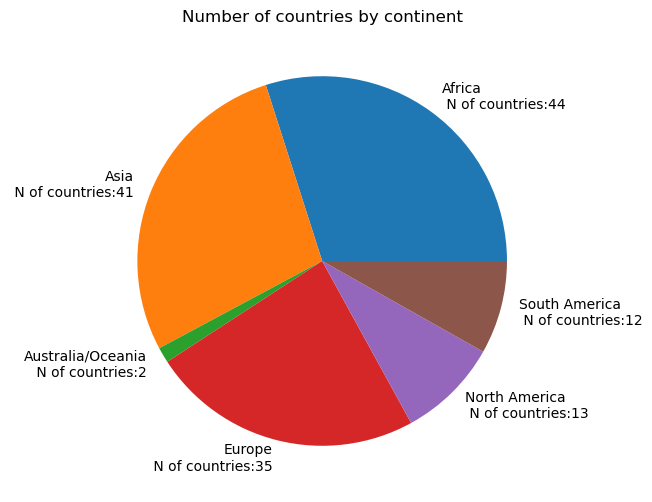

In [ ]:
plt.figure(figsize=(6,6))
happiness_covid_merge.groupby("Continent")["Country"].count().plot.pie\
(labels=[f'{continent}\n N of countries:{count}' for continent, count in countries_by_continent.items()])
plt.title("Number of countries by continent");
plt.ylabel("");

Before we investigate how some of the variables correlated, let's see if the "Total deaths", "Total recovered" and "Life ladder" differ significantly between continents.

We'll assume a null-hypothesis (H0) that there is no significant different between median scores of the aforementioned variables and an alternative hypothesis (H1) that there is significant difference.

We'll use the **Mann-Whitney U Test** for the comparison.

In [ ]:
def mannwhit_test(df, continent_1=None,continent_2=None, comparison=None, alpha=0.01):

    """
    Calculate the Mann-Whitney U Test result between two continents
    and a variable of choice, and return whether the p-value is less
    than the alpha value (default alpha value = 0.001).
    If any of the continents two continents and comparison are not selected
    the function will return a notification.
    """

    if continent_1 == None or continent_2 ==  None or column == None:
        return "No continents and/or column selected"

    statistic, p_value = mannwhitneyu(df.loc[continent_1, comparison],
                                      df.loc[continent_2, comparison])

    print(f"Difference in '{comparison}' between {continent_1} and {continent_2}\n")
    print(f"Statistic: {statistic}\n")
    print(f"p_value: {p_value}\n")

    if p_value < alpha:
        print("Reject the null hypothesis.\n")
        print("-----------------------------")
    else:
        print("Fail to reject the null hypothesis.")
        print("-----------------------------")

    return statistic, p_value

In [ ]:
#Add the continents, total deaths and total recovered for each country in the "happiness_data"
happiness_data_with_conts = happiness_data.merge(covid_19_summary[["Country","Continent","Total deaths","Total recovered"]], on="Country", how="left")

In [ ]:
#Group by Continent and Year and aggregate
continent_by_year_data = happiness_data_with_conts.groupby(["Continent","Year"]).agg({"Life ladder": "median",
                                                                                    "Total deaths": "sum",
                                                                                    "Total recovered": "sum"})

In [ ]:
columns_test = ["Total deaths", "Total recovered", "Life ladder"]
continents_test = ['Asia', 'Europe', 'Africa', 'South America','North America']

In [ ]:
#This loop will go through all values in "columns_test" and
#all values in continents_test and perform the Mann-Whitney U test
#on all combinations of continents and columns

for column in columns_test:
    counter = 1
    for index1, continent1 in enumerate(continents_test):
        for index2, continent2 in enumerate(continents_test):
            if index2+counter == len(continents_test):
                break
            print(mannwhit_test(continent_by_year_data, continent1, continents_test[index2+counter], column))
        counter+=1

    if index1 == 4:
        counter = 0
        continue

Difference in 'Total deaths' between Asia and Europe

Statistic: 45.0

p_value: 0.0002234725753170319

Reject the null hypothesis.

-----------------------------
(45.0, 0.0002234725753170319)
Difference in 'Total deaths' between Asia and Africa

Statistic: 320.0

p_value: 6.258023064504621e-07

Reject the null hypothesis.

-----------------------------
(320.0, 6.258023064504621e-07)
Difference in 'Total deaths' between Asia and South America

Statistic: 34.0

p_value: 3.598321501040068e-05

Reject the null hypothesis.

-----------------------------
(34.0, 3.598321501040068e-05)
Difference in 'Total deaths' between Asia and North America

Statistic: 307.0

p_value: 4.570576644816297e-06

Reject the null hypothesis.

-----------------------------
(307.0, 4.570576644816297e-06)
Difference in 'Total deaths' between Europe and Africa

Statistic: 324.0

p_value: 3.1117018077996114e-07

Reject the null hypothesis.

-----------------------------
(324.0, 3.1117018077996114e-07)
Difference in 'T

We fail to reject the null hypothesis overall in only three "Life Ladder" comparisons:
1. Europe and South America
2. Europe and North America
3. South America and North America

This would suggest that in terms of happiness and dealing with recoveries and deaths, different factors were at play in different continents (most certainly in different countries as well but this would require an analysis with greater granularity and more details).

Group by continent and check how some of the variables correlate.

<Axes: >

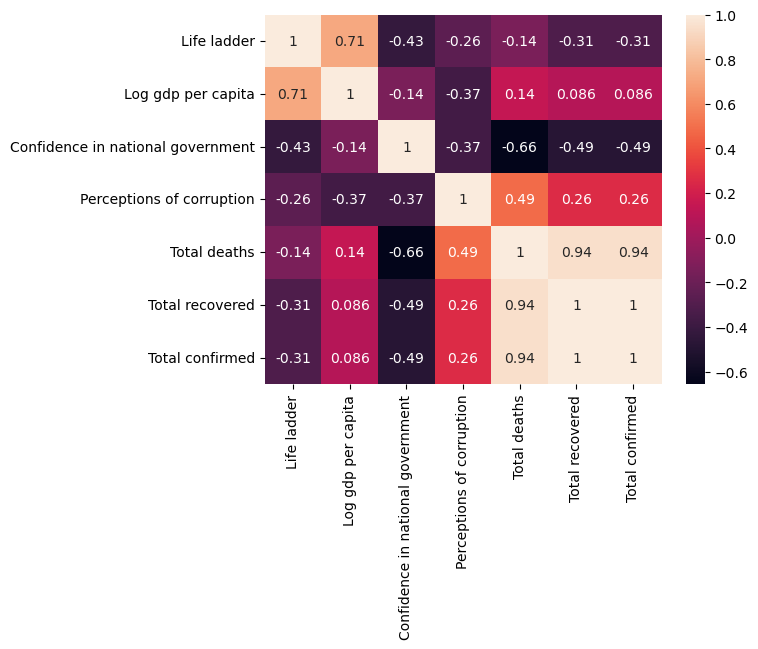

In [ ]:
#Create a heatmap and annotate the correlations
sns.heatmap(happiness_covid_merge.groupby("Continent").agg({"Life ladder": "median",
                                                "Log gdp per capita": "median",
                                                "Confidence in national government": "median",
                                                "Perceptions of corruption":"median",
                                               "Total deaths": "sum",
                                               "Total recovered" : "sum",
                                               "Total confirmed": "sum"
                                               }).sort_values(by="Life ladder", ascending=False).corr(method="spearman"), annot=True)

Returning to the first question posed in the notebook title - we can conclude that there is no correlation between how happy a country is and how well it managed to prevent deaths of Covid-19.

While we can't see significant correlations between "Life ladder" and "Total deaths" or "Total recovery", we can notice two moderate correlations related to "Total deaths" and "Perception of corruption" which is positive with score of 0.49 and "Total deaths" and "Confidence in national government"  with negative correlation of -0.66.

The correlations are present only if we group by "Continent" and aggregate afterwords but not if we group by "Country" which seems like an example of the Simpson's Paradox.

Due to some corroboratory papers and articles considering the effect of perceived corruption and government trust, we're going to accept the correlations at face value, not delving too deep on whether this is an example of the Simpson's Paradox or not.

1. https://www.transparency.org/en/news/cpi-2020-research-analysis-why-fighting-corruption-matters-in-times-of-covid-19 - WHY FIGHTING CORRUPTION MATTERS IN TIMES OF COVID-19
2. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8144822/ - Trust in government regarding COVID-19 and its associations with preventive health behaviour and prosocial behaviour during the pandemic: a cross-sectional and longitudinal study


Let's see if the happiness scores change drastically in any direction from 2020 till 2022 compared to a three year period prior (2017 till 2019).

In [ ]:
#Add the continents for each country in the "happiness_data"

happiness_data_conts = happiness_data.merge(covid_19_summary[["Country","Continent"]], on="Country", how="left")

In [ ]:
#Filter only the relevant years

happiness_data_conts = happiness_data_conts[["Continent","Country", "Year", "Life ladder"]][(happiness_data_conts["Year"] >= 2017) & (happiness_data_conts["Year"] <= 2022)]

In [ ]:
#Group by continents

continent_groups = pd.DataFrame(happiness_data_conts.groupby(["Continent","Year"])["Life ladder"].median()).reset_index()

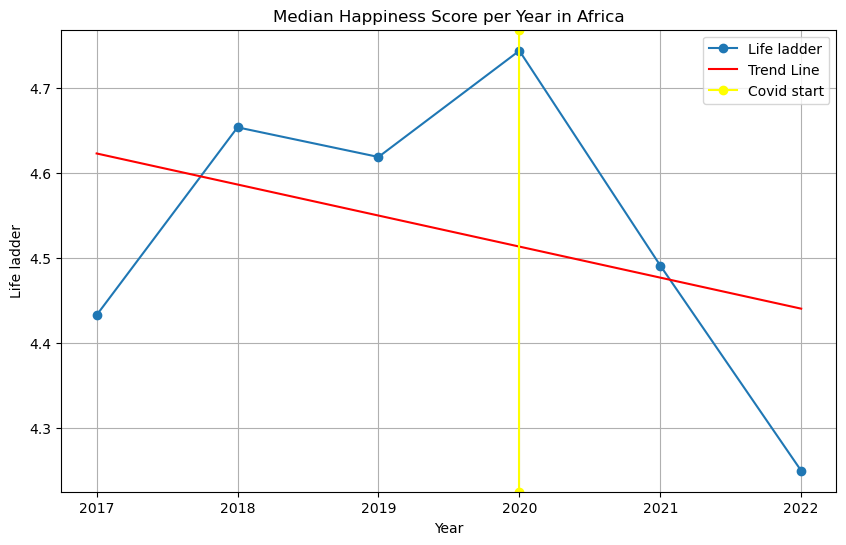

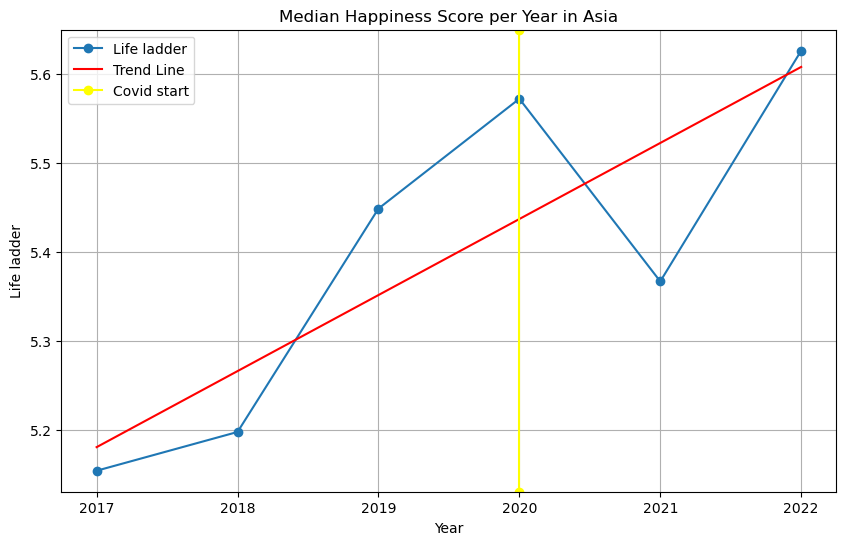

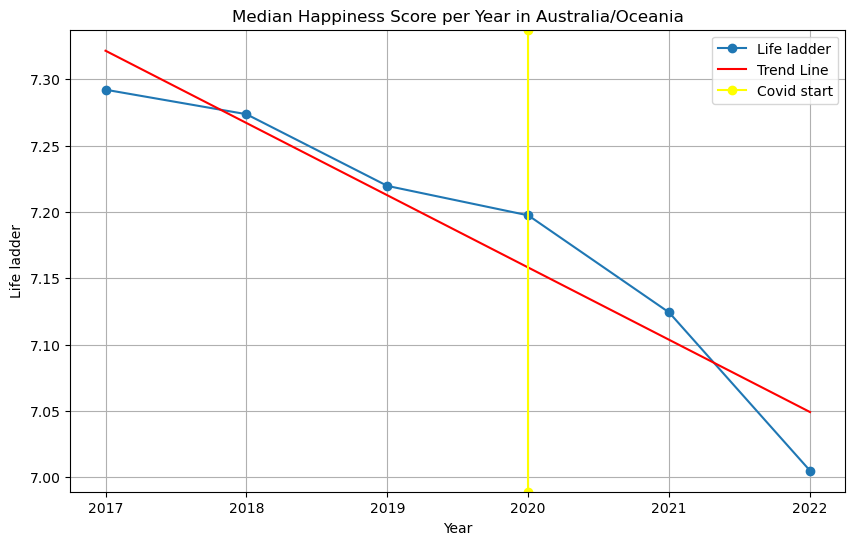

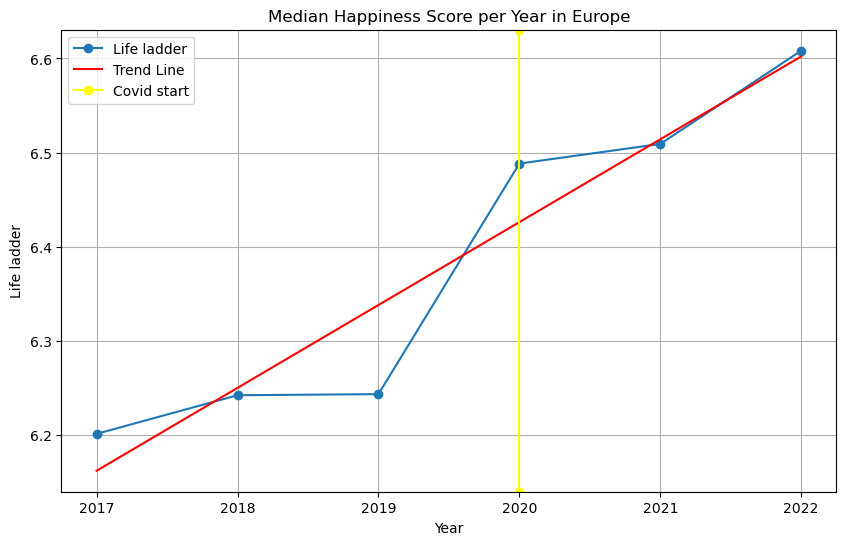

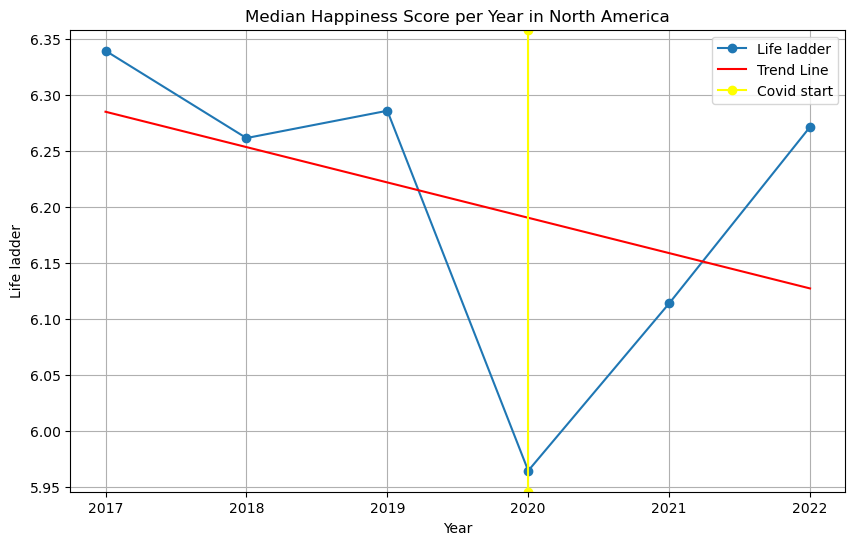

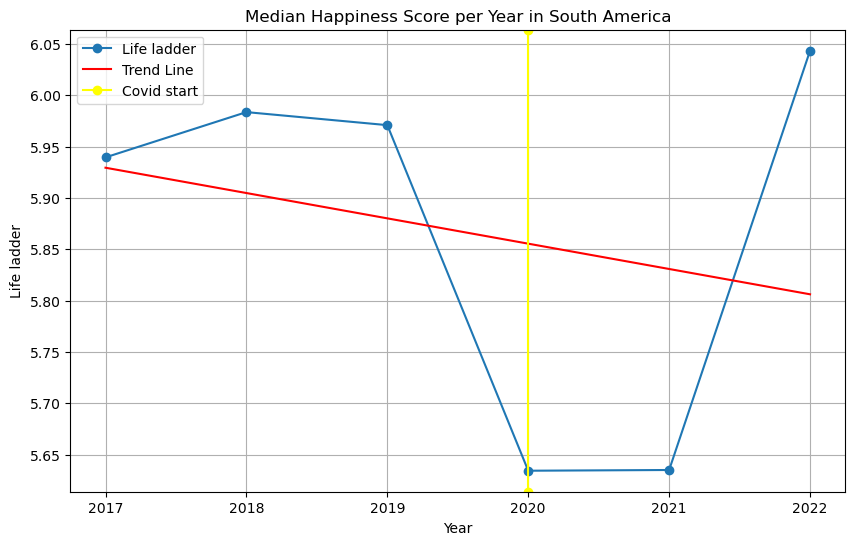

In [ ]:
continents = continent_groups['Continent'].unique()

#Loop through each country, calculate trend, and plot
for continent in continents:
    continent_data = continent_groups[continent_groups['Continent'] == continent]

    #Calculate linear regression
    coefficients = np.polyfit(continent_data['Year'], continent_data['Life ladder'], 1)
    trend_line = np.polyval(coefficients, continent_data['Year'])

    # Plot time series with trend line
    plt.figure(figsize=(10, 6))
    plt.plot(continent_data['Year'], continent_data['Life ladder'], marker='o', label='Life ladder')
    plt.plot(continent_data['Year'], trend_line, color='red', label='Trend Line')

    #Add a vertical line at year 2020 (the year that Covid-19 was declared a pandemic)
    plt.axvline(x=2020, marker="o", color="yellow", label="Covid start")
    plt.xlabel('Year')
    plt.ylabel('Life ladder')
    plt.title(f'Median Happiness Score per Year in {continent}')
    plt.legend()
    plt.grid()
    plt.show()

Before we analyze the line plots, we have to note that "Australia/Oceania" has only two countries in the current dataset which makes it a bad fit for a continent-level evaluation.

However, Europe and Asia are continuing their upward "Life ladder" trend that started before the pandemic.
Both in North and South America higher values of "Life ladder" were observed before the pandemic with a sharp drop in 2020 and a rise again afterwords.
Africa is the only continent in a decline since 2020.

The infered from the plots is confirmed by the **World Happiness Index 2022 report** as the report comments on the effects that Covid-19 might have had on general happiness and well-being.
All in all, citing the report *"life evaluations have been fairly stable during two years of COVID-19, matched by modest changes in the global rankings"*.

https://worldhappiness.report/ed/2022/happiness-benevolence-and-trust-during-covid-19-and-beyond/#how-has-well-being-under-covid-19-varied-among-population-subgroups-in-2020-and-2021 - Happiness, Benevolence, and Trust During COVID-19 and Beyond


# References and cited sources:

### Data:
1. World Happiness Report, 2005-Present - https://www.kaggle.com/datasets/usamabuttar/world-happiness-report-2005-present
2. Covid-19 Global Dataset - https://www.kaggle.com/datasets/josephassaker/covid19-global-dataset
3. Latitude and Longitude for Every Country and State - https://www.kaggle.com/datasets/paultimothymooney/latitude-and-longitude-for-every-country-and-state

### Papers and articles (in order of appearance in the notebook from top to bottom):

1. The Taliban in Afghanistan - https://www.cfr.org/backgrounder/taliban-afghanistan
2. Democracy Index 2022 - https://www.eiu.com/n/campaigns/democracy-index-2022/
3. Challenges in reported COVID-19 data: best practices and recommendations for future epidemics - https://gh.bmj.com/content/6/5/e005542
Limitations of COVID-19 testing and case data for evidence-informed health policy and practice - https://health-policy-systems.biomedcentral.com/articles/10.1186/s12961-023-00963-1
4. Factors influencing international collaboration on the prevention of COVID-19 - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9458694/#:~:text=Seven%20categories%20influencing%20international%20collaboration,(7)%20process%2Faction
5. Problems with the accurate reporting of COVID-19 statistics in Iran - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7682961
6. Using Python to create a world map from a list of country names - https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10
7. Analysing COVID-19 pandemic through cases, deaths, and recoveries - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7414737/
8. WHY FIGHTING CORRUPTION MATTERS IN TIMES OF COVID-19 - https://www.transparency.org/en/news/cpi-2020-research-analysis-why-fighting-corruption-matters-in-times-of-covid-19
9. Trust in government regarding COVID-19 and its associations with preventive health behaviour and prosocial behaviour during the pandemic: a cross-sectional and longitudinal study - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8144822/
10. Happiness, Benevolence, and Trust During COVID-19 and Beyond - https://worldhappiness.report/ed/2022/happiness-benevolence-and-trust-during-covid-19-and-beyond/#how-has-well-being-under-covid-19-varied-among-population-subgroups-in-2020-and-2021